## Homework 4 - Classification
### Mazin Elnour & Sharjil Khan

- [Initial Data Prep](#load)
    - [Load the data and explore](#load)
    - [Feature Engineering: Look for redundant features and remove them](#remove)
    - [Feature Engineering: Account for Subject, Phase & State and remove them ](#add_feature)
    - [Split into training and test and balance the training set](#split)
    - [Standardise](#std)
    - [Apply PCA](#pca)
    - [List of Variables to be used by models](#variables)


- [XGBoost](#xgboost)
- [Logistic Regression](#logistic)
- [Naive Bayes](#nb)
- [Random Forest](#rf)
- [LDA](#lda)
- [Support Vector Machine](#svm)
- [Stacked Models](#stack)

-------

## IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

from numpy import loadtxt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

import re
# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold

# "Support Vector Classifier" 
from sklearn.svm import SVC 
import sklearn.linear_model
import sklearn.svm

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

dark2_cmap=ListedColormap(dark2_colors)
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

import warnings
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

## SOME HELPER FUNCTIONS

In [3]:
targets = ['zeros', 'ones']
def show_confusion_matrix(cm, target_names):
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_stats(clf, x_train, x_test, y_train, y_test):
    clf.fit(x_train, y_train)

    pred = clf.predict(x_test)
    y_score = clf.predict_proba(x_test)[:,1]

    print("Number of mislabeled points out of a total %d testing points : %d"
          % (x_test.shape[0],(y_test != pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the testing set: ", clf.score(x_test, y_test)))
    report = precision_recall_fscore_support(y_test, pred, average='binary')
    acc_score = accuracy_score(y_test, pred)
    cm = confusion_matrix(pred, y_test)
    specificity = cm[0][0]/ (cm[0][0] + cm[1][0])
    
    print("\nprecision = %0.3f, recall = %0.3f, specificity= %0.3f F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], specificity, report[2], acc_score))
    print("*********** AUC for ROC = %0.3f *********************\n" % metrics.roc_auc_score(y_test, y_score))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the testing set: \n",pd.DataFrame(cm) )
    show_confusion_matrix(cm, targets)
    
    
def generate_file (model, test_1, file_name):
      preds = model.predict_proba(test_1) #submit these predictions
      # TO CREATE THE FILE FROM PREDICTIONS, preds is returned by pred_proba
      submithis = pd.DataFrame([test_1.index,preds[:,1]]).T
      submithis.columns = ['id','output']
      submithis.id = submithis.id.astype(int)
      submithis.to_csv(file_name,index=False)  #~0.68756
      return submithis
    
def feature_importance(importances, column_names, top_n):
    features = column_names
    indices = np.argsort(importances)[::-1][:top_n] 
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.xlabel('Relative Importance')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.show()



<a id='load'></a>
## LOAD THE DATA AND SOME INITIAL DATA EXPLORATION
Load the data and explore how many features, the types of features and look for any obvious issues with the data.

In [4]:
# LOAD THE DATA
train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')

In [5]:
print(train.shape)
print(test.shape)

(4584, 670)
(1732, 669)


In [6]:
#pandas_profiling.ProfileReport(train) #Commented out because it is too time consuming to run

In [7]:
train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z217,z218,z219,z220,z221,z222,subject,phase,state,output
0,0,0,0,1,-323.106605,2.694366,-1.987520,261.092784,0.013704,0.000100,...,-0.004930,-0.005554,5.246375,-7.534092,3.530736,-0.539045,K,3,C,1
1,0,0,0,1,-376.084691,0.969696,-6.933765,355.311648,0.030292,-0.000153,...,0.022757,0.052506,-3.727741,-2.854443,-0.699268,-0.054074,A,4,C,1
2,0,0,0,0,91.955425,2.621643,-2.581162,51.357206,0.036668,-0.000104,...,-0.086813,-0.101497,-7.510594,19.564182,-17.008130,4.945392,D,3,C,1
3,0,0,0,1,-391.814586,1.866914,-2.510799,382.900317,0.007947,-0.000028,...,0.030856,-0.161398,-6.435819,2.174453,-0.153956,-0.003958,G,2,C,0
4,0,0,0,0,-363.823732,2.951346,-3.726368,330.527539,0.010074,-0.000004,...,-0.017226,-0.016454,-2.581403,3.011932,-1.281361,0.192647,C,2,C,1


In [8]:
test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z216,z217,z218,z219,z220,z221,z222,subject,phase,state
0,0,0,0,1,4.665949,0.083412,-17.397081,0.067865,0.005895,0.000012,...,-0.017574,-0.004402,0.016508,-540.645279,-1511.001159,-1408.385976,-437.807290,E,4,D
1,0,0,0,0,-398.299487,0.784032,-10.785768,403.784446,0.070405,0.000180,...,0.029533,0.113692,0.088024,-3.140961,-0.658456,-0.140010,-0.011017,H,4,D
2,0,0,0,1,-380.902140,0.671324,-9.265829,361.841929,0.006937,0.000025,...,-0.006361,0.005852,-0.003745,-14.340790,4.182214,-0.549953,0.019553,C,4,B
3,0,0,0,1,-342.784123,0.469414,-8.044287,293.043601,0.007217,-0.000021,...,0.001950,-0.003426,-0.011191,251.659680,-441.129598,256.986592,-49.745359,H,1,C
4,0,0,0,1,6.248502,0.252336,-5.398056,0.110097,0.005573,0.000010,...,-0.001916,-0.015666,-0.015960,-137.847658,-377.758402,-345.673251,-105.633150,E,4,B


In [9]:
train.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z215,z216,z217,z218,z219,z220,z221,z222,phase,output
count,4584.0,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,...,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000,4584.000000
mean,0.0,0.000218,0.000218,0.625436,-270.199043,1.801323,-4.654634,253.735831,0.021039,-0.000004,...,-0.001628,0.001754,0.001374,0.001404,-57.916190,96.554052,-52.630948,28.735112,2.519634,0.844895
std,0.0,0.014770,0.014770,0.484063,163.971643,1.143173,3.714967,147.405918,0.026384,0.000472,...,0.099405,0.070156,0.078443,0.091211,243.742549,597.912778,599.208382,217.842477,1.158998,0.362044
min,0.0,0.000000,0.000000,0.000000,-474.588020,-0.237454,-19.295360,0.026692,0.005007,-0.004008,...,-3.805788,-0.999448,-1.886137,-1.264762,-2182.646032,-6674.270678,-8311.046315,-3671.954955,1.000000,0.000000
25%,0.0,0.000000,0.000000,0.000000,-383.328439,0.815996,-6.708809,108.809493,0.007504,-0.000081,...,-0.022183,-0.018118,-0.017379,-0.021389,-31.817506,-1.715924,-11.180312,-0.050475,1.000000,1.000000
50%,0.0,0.000000,0.000000,1.000000,-351.317222,1.578367,-3.324030,313.157669,0.011282,0.000003,...,-0.000383,0.000673,0.000374,0.000507,-2.919292,0.098110,-0.492411,0.001721,3.000000,1.000000
75%,0.0,0.000000,0.000000,1.000000,-177.051209,2.741501,-2.027700,370.832095,0.021861,0.000083,...,0.020556,0.020727,0.019355,0.022440,-0.277689,13.684733,-0.032526,0.483496,4.000000,1.000000
max,0.0,1.000000,1.000000,1.000000,418.085156,4.368496,6.250661,588.309282,0.423408,0.003588,...,0.916725,0.708321,1.548114,2.949784,2408.234281,6111.797852,6412.126601,2816.376179,4.000000,1.000000


In [10]:
test.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z214,z215,z216,z217,z218,z219,z220,z221,z222,phase
count,1732.0,1732.0,1732.0,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,...,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000,1732.000000
mean,0.0,0.0,0.0,0.571016,-277.885554,1.604938,-5.414832,255.823559,0.021758,0.000008,...,-0.003202,-0.001151,-0.002507,-0.000998,-0.000054,-110.276709,-121.265455,-222.574598,-38.935670,2.570439
std,0.0,0.0,0.0,0.495074,154.845148,1.147339,4.257535,144.203953,0.026765,0.000373,...,0.136569,0.093555,0.081933,0.089583,0.104841,391.650246,1081.345964,990.468100,319.750306,1.206186
min,0.0,0.0,0.0,0.000000,-467.276129,-0.107885,-20.611523,0.061916,0.004730,-0.002895,...,-1.691499,-1.269537,-1.696589,-0.859393,-1.891506,-3423.935457,-9559.626928,-8897.400348,-2760.528477,1.000000
25%,0.0,0.0,0.0,0.000000,-382.645885,0.604385,-7.819653,137.782812,0.007411,-0.000072,...,-0.026140,-0.022620,-0.021943,-0.018853,-0.022743,-32.187216,-1.156637,-12.301322,-0.030173,1.000000
50%,0.0,0.0,0.0,1.000000,-358.278216,1.351021,-3.725531,324.514646,0.012295,0.000002,...,-0.001551,-0.001223,0.000767,-0.000838,-0.000034,-2.742422,0.185153,-0.486775,0.005631,3.000000
75%,0.0,0.0,0.0,1.000000,-214.315606,2.503754,-2.284565,367.989031,0.024584,0.000082,...,0.023600,0.021058,0.020423,0.017940,0.021003,-0.247839,8.489298,-0.017909,0.352890,4.000000
max,0.0,0.0,0.0,1.000000,411.846894,4.315517,2.279343,554.445563,0.378385,0.002761,...,2.641951,0.810623,0.608914,2.039491,1.835451,1674.130664,5958.441159,5039.275789,2215.886665,4.000000


In [11]:
train_features = train.columns
test_features = test.columns
print(set(train_features)-set(test_features))

{'output'}


In [12]:
# Notice that the dataset has unbalanced output classes
train.output.value_counts()

1    3873
0     711
Name: output, dtype: int64

<a id='remove'></a>

## REMOVE CORRELATED FEATURES AND FEATURES WITH CONSTANT VALUES
Used pandas profiling library to detect features that are correlated to other features and can be removed.  
Also removed all features that have constant values for all dataset

In [13]:
try: profile
except NameError:
    profile = pandas_profiling.ProfileReport(train)
    profile.to_file("train_profile.html")
    rejected_variables = profile.get_rejected_variables()

In [14]:
train_r = train.drop(columns=rejected_variables)
test_r = test.drop(columns=rejected_variables)
train_r.shape, test_r.shape

((4584, 392), (1732, 391))

In [15]:
for col in train_r.columns:
    if len(train_r[col].unique()) == 1:
        train_r.drop(col,inplace=True,axis=1)
        test_r.drop(col,inplace=True,axis=1)

In [16]:
train_r.shape, test_r.shape

((4584, 284), (1732, 283))

In [17]:
REDUCE_FEATURES = True
if REDUCE_FEATURES:
    train = train_r
    test = test_r

<a id='add_feature'></a>

## ACCOUNT FOR SUBJECT, PHASE & STATE AND REMOVE THE COLUMNS
Subject, Phase and State are categorical variables and need to be treated as such. But since some of these catagories are not present in the test set, it is best to store some of the best information from them and remove the original columns from the data set. 

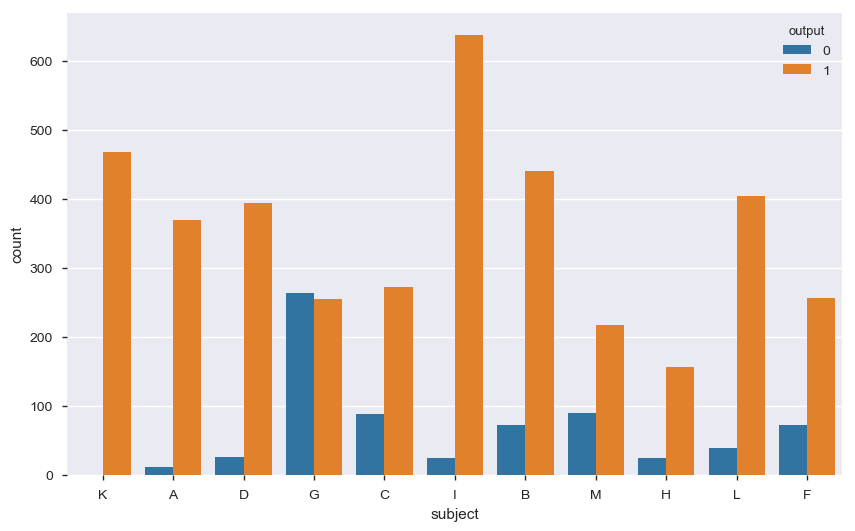

In [18]:
f, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x="subject", hue="output", data=train);

In [19]:
train['indicator']='train'
test['indicator']='test'

Y = train.output
train.drop('output',inplace=True, axis=1)

In [20]:
train_test = pd.concat([train,test])
train_test.reset_index(inplace=True, drop=True) #drop index
train_test.shape

(6316, 284)

In [21]:
#Creating Features
train_test['SubjectK'] = 0 
train_test.loc[train_test[train_test.subject=='K'].index,'SubjectK']=1  

In [22]:
#Step by step
i1 = train_test[((train_test.phase==1) & (train_test.subject=='A'))].index
arr = np.zeros(train_test.shape[0],dtype=int)
arr[i1]=1
train_test['SubA_Phase1']=arr

#concise
train_test['SubI_Phase1'] = 0
train_test.loc[train_test[((train_test.phase==1) & (train_test.subject=='I'))].index,'SubI_Phase1'] = 1

train_test['SubM_Phase1'] = 0
train_test.loc[train_test[((train_test.phase==1) & (train_test.subject=='M'))].index,'SubM_Phase1'] = 1

train_test['SubA_Phase2'] = 0
train_test.loc[train_test[((train_test.phase==2) & (train_test.subject=='A'))].index,'SubA_Phase2'] = 1

train_test['SubF_Phase2'] = 0
train_test.loc[train_test[((train_test.phase==2) & (train_test.subject=='F'))].index,'SubF_Phase2'] = 1

train_test['SubI_Phase3'] = 0
train_test.loc[train_test[((train_test.phase==3) & (train_test.subject=='I'))].index,'SubI_Phase3'] = 1

train_test['SubL_Phase3'] = 0
train_test.loc[train_test[((train_test.phase==3) & (train_test.subject=='L'))].index,'SubL_Phase3'] = 1

train_test['SubL_Phase4'] = 0
train_test.loc[train_test[((train_test.phase==4) & (train_test.subject=='L'))].index,'SubL_Phase4'] = 1
#possibly add I, phase4 = 1 too.

In [23]:
train_data = train_test[train_test.indicator=='train']
test_output = train_test[train_test.indicator=='test']
train_data.reset_index(inplace=True,drop=True)
test_output.reset_index(inplace=True,drop=True)

train_data = train_data.drop(['state','subject','phase','indicator'], axis=1)
test_output = test_output.drop(['state','subject','phase','indicator'], axis=1)

<a id='split'></a>
## SPLIT THE TRAINING DATA INTO TRAIN AND TEST DATA (For local testing)  
## BALANCE THE TRAINING SET TO REPRESENT THE OUTPUT CLASS EQUALLY

We set aside 20% of the training data as a test set to score the different models.  
Also used the SMOTE library to balance the remaining training data using bootstrapping with replacement.

In [24]:
test_size = 0.20
# SPLIT THE TRAIN DATA INTO TRAIN AND TEST 
X_train_unbalanced, X_test_unbalanced, y_train_unbalanced, y_test_unbalanced = train_test_split(train_data, Y, test_size=test_size, random_state=101)

# GET A BALANCED VERSION OF THE TRAIN DATA
sm = SMOTE(random_state = 12, ratio = 1.0)
X_train_balanced, y_train_balanced = sm.fit_sample(X_train_unbalanced, y_train_unbalanced)
X_train_balanced = pd.DataFrame(X_train_balanced, columns=X_train_unbalanced.columns)
y_train_balanced = pd.DataFrame(y_train_balanced)[0]

## CHOOSE BETWEEN BALANCED (equal 0s and 1s in output) OR UNBALANCED DATA GOING FORWARD

In case we want to use the unbalanced data in some model in the future, we can flip the BALANCED variable

In [25]:
##################################################
## CHOOSE WHICH DATA SET TO USE GOING FORWARD ####
##################################################
BALANCED = True

if BALANCED : 
    X_train = X_train_balanced 
    y_train = y_train_balanced
else : 
    X_train = X_train_unbalanced
    y_train = y_train_unbalanced   

    
X_test = X_test_unbalanced
y_test = y_test_unbalanced

## RECHECK THE SIZES OF THE TRAINING AND TEST SET
Making sure that the new training data is balanced and the training set and the test set has the expected number of rows and columns

In [26]:
print("TRAINING:")
print(X_train.shape)
print(y_train.shape)
print("0s and 1s split:")
print (y_train.value_counts())

print("\nTEST:")
print(X_test.shape)
print(y_test.shape)
print("0s and 1s split:")
print (y_test.value_counts())

print("\nOutput Test Dataset size:")
print(test_output.shape)

TRAINING:
(6214, 289)
(6214,)
0s and 1s split:
1    3107
0    3107
Name: 0, dtype: int64

TEST:
(917, 289)
(917,)
0s and 1s split:
1    766
0    151
Name: output, dtype: int64

Output Test Dataset size:
(1732, 289)


<a id='std'></a>
## STANDARDISE THE DATA

Standardise all the conditional variables and leave the catagorical variables untouched

In [27]:
bin_features = ['SubjectK', 'SubA_Phase1', 'SubI_Phase1', 'SubM_Phase1','SubA_Phase2','SubF_Phase2','SubI_Phase3','SubL_Phase3','SubL_Phase4']


# SAVE THE BINARY COLUMNS
X_train_binary = X_train[bin_features].reset_index(drop=True)
X_test_binary = X_test[bin_features].reset_index(drop=True)
test_output_binary = test_output[bin_features].reset_index(drop=True)


# APPLY TRANSFORMS
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test_std = pd.DataFrame(X_test_std, columns=X_test.columns)


#Also Standardize the OUTPUT TEST SET FOR LATER USE
test_output_std = std_scale.transform(test_output)
test_output_std = pd.DataFrame(test_output_std, columns=test_output.columns)

# Restore the Binary column values
X_train_std[bin_features] = X_train_binary
X_test_std[bin_features] = X_test_binary
test_output_std[bin_features] = test_output_binary

# CHECK TO MAKE SURE THE VARIABLES ARE STANDARDIZED
X_test_std.describe()


C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.


,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,...,z221,SubjectK,SubA_Phase1,SubI_Phase1,SubM_Phase1,SubA_Phase2,SubF_Phase2,SubI_Phase3,SubL_Phase3,SubL_Phase4
count,917.000000,9.170000e+02,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,...,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000,917.000000
mean,0.001091,-1.268672e-02,0.037178,0.138103,0.071927,0.008432,-0.128961,0.034051,-0.041621,0.027680,...,0.077312,0.110142,0.020720,0.019629,0.018539,0.018539,0.010905,0.035987,0.018539,0.030534
std,0.033023,1.371179e-16,1.038109,1.090912,1.037591,1.065919,1.031309,1.287928,1.180505,0.968126,...,1.080093,0.313237,0.142522,0.138798,0.134963,0.134963,0.103913,0.186359,0.134963,0.172146
min,0.000000,-1.268672e-02,-1.349887,-1.196635,-1.484173,-3.976127,-1.861212,-0.668840,-9.845665,-6.092336,...,-8.300370,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,-1.268672e-02,-1.349887,-0.631551,-0.809798,-0.637265,-1.147203,-0.572359,-0.200904,-0.207153,...,0.124962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,-1.268672e-02,0.813274,-0.413562,-0.148683,0.378476,0.280858,-0.413709,-0.009325,-0.014983,...,0.146043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,-1.268672e-02,0.813274,0.790634,0.928194,0.789955,0.705911,-0.002147,0.176065,0.158810,...,0.147118,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,-1.268672e-02,0.813274,4.644476,2.423418,3.022886,1.989858,16.984373,6.723921,12.706115,...,12.218014,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a id='pca'></a>
## APPLY PCA TO REDUCE DIMENSION

Apply PCA to reduce the number of dimensions.  
Looking at the plot below, we can see that we are able to capture about 90% of the variance using 110 PCA components

(917, 110)
(6214, 110)
(917,)
(6214,)
(1732, 110)


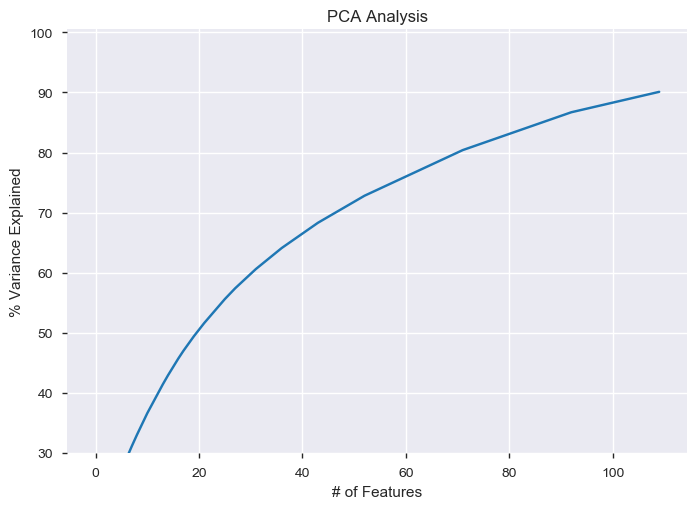

In [184]:
PCA_components = 110

X_train_std = X_train_std.apply(lambda x: pd.to_numeric(x,errors='ignore'))
X_test_std = X_test_std.apply(lambda x: pd.to_numeric(x,errors='ignore'))
test_output_std = test_output_std.apply(lambda x: pd.to_numeric(x,errors='ignore'))

pca = PCA(n_components=PCA_components)
X_train_PCA = pca.fit_transform(X_train_std)

# Transform the test data using the same PCA dimensions
X_test_PCA = pca.transform(X_test_std)

#Also apply PCA to the OUTPUT TEST SET FOR LATER USE
test_output_PCA = pca.transform(test_output_std)


# https://etav.github.io/python/scikit_pca.html
var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.style.context('seaborn-whitegrid')
plt.plot(var)

print(X_test_PCA.shape)
print(X_train_PCA.shape)
print(y_test.shape)
print(y_train.shape)
print(test_output_PCA.shape)


<a id='variables'></a>
# VARIABLES THAT CAN BE USED WHILE BUILDING THE MODEL 
## UNBALANCED DATA
X_train_unbalanced   
X_test_unbalanced   
y_train_unbalanced   
y_test_unbalanced   

Data Set on which output file is to be generated on:
test_output

## BALANCED DATA
if BALANCE is set to 'TRUE'  
X_train   
y_train   

OR 

X_train_balanced   
y_train_balanced[0]  

Only need to train on balanced data. no need to balance any test data set  
Data Set on which output file is to be generated on:  
test_output

## STANDARDIZED DATA 
if BALANCE is set to 'TRUE' the standardizatoin will happen on BALANCED DATA  

X_train_std   
X_test_std 

Data Set on which output file is to be generated on:  
test_output_std  



## DIMENSIONS REDUCED USING PCA
if BALANCE is set to 'TRUE' the standardizatoin & PCA will be applied on BALANCED DATA  

X_train_PCA  
X_test_PCA  

Data Set on which output file is to be generated on:  
test_output_PCA

<a id='xgboost'></a>
## XGBOOST:    
We first used gridsearchcv to find some good values for xgboost parameters based on 3 folds cross validation.
Then we fit an xgboost model with the best parameters found by cross validation and get a score on the test set.
XGBoost also provides some ranking of important features. We plan on trying to use these important features again in the stacked model to see if they can help improve the scores.

#### USE GRIDSEARCHCV TO DETERMINE n_estimators & learning rate for XGBOOST

In [185]:
# DO A GRIDSEARCH ON XGBOOST MODEL
n_estimators = [ 900, 1000, 1100]  
learning_rate = [0.1, 0.5, 0.01, 0.05,0.001]  

param_grid1 = {'learning_rate':learning_rate, 'n_estimators':n_estimators}
param_grid1

{'learning_rate': [0.1, 0.5, 0.01, 0.05, 0.001],
 'n_estimators': [900, 1000, 1100]}

In [ ]:
model = xgb.XGBClassifier()
grid_search = GridSearchCV(model,param_grid=param_grid1, scoring="roc_auc", verbose=1 )
grid_search.fit(X_train, y_train) #Default 3 folds

C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 15 candidates, totalling 45 fits


In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)  

Number of mislabeled points out of a total 917 testing points : 324
('The hit rate on the testing set: ', 0.6466739367502726)

precision = 0.905, recall = 0.645, specificity= 0.656 F1 = 0.753, accuracy = 0.647

*********** AUC for ROC = 0.742 *********************

          0         1
0  0.266846  0.498168
1  0.140162  0.904762 

The confusion matrix on the testing set: 
     0    1
0  99  272
1  52  494


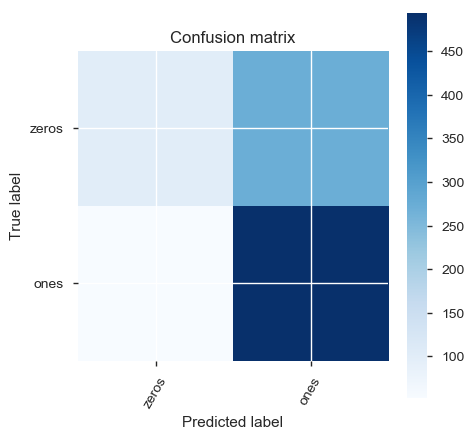

In [28]:
# From the Above scores I pick 700 as the optimal number of estimators.
xgb_model = xgb.XGBClassifier(seed=82, n_estimators=1200 , max_depth=4, colsample_bylevel=0.8,
                        colsample_bytree=0.7,learning_rate=0.01, reg_lambda=0.1 , 
                        scale_pos_weight = 0.18357862, eval_metric='auc') #missing = -999

print_stats(xgb_model, X_train, X_test, y_train, y_test)


In [29]:
xgb_model.fit(X_train, y_train, eval_metric='auc')
_ = generate_file (xgb_model, test_output, "xgb_model.csv") 

#### GET FEATURE IMPORTANCE FROM XGBOOST

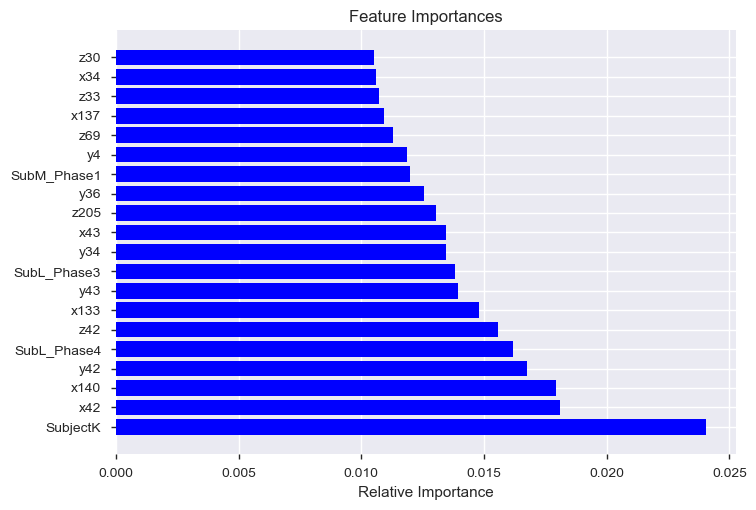

In [30]:
feature_importance(xgb_model.feature_importances_, X_train.columns, 20)

<a id='logistic'></a>
## LOGISTIC REGRESSION:

Tune Logistic regression parameters using 3 fold cross validation and fit the best model to get a score on the test set.

In [ ]:
lr_params = [
  {'penalty': ['l1'], 'solver': [ 'liblinear',  'saga']},
  {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag']},
 ]

lr = LogisticRegression(max_iter = 500)  
grid = GridSearchCV(lr, param_grid = lr_params, cv=3, scoring = 'roc_auc', verbose=1)
grid.fit(X_train_PCA, y_train)

print(grid.best_score_)
print(grid.best_params_)  

Number of mislabeled points out of a total 917 testing points : 282
('The hit rate on the testing set: ', 0.6924754634678298)

precision = 0.922, recall = 0.691, specificity= 0.702 F1 = 0.790, accuracy = 0.692

*********** AUC for ROC = 0.763 *********************

          0         1
0  0.309038  0.412892
1  0.131195  0.921603 

The confusion matrix on the testing set: 
      0    1
0  106  237
1   45  529


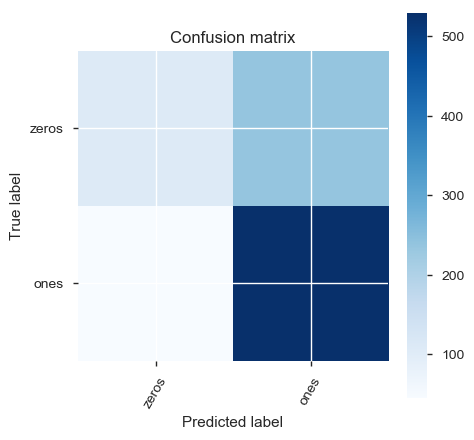

In [31]:
# USE THE BEST PARAMS FOUND BY GRID SEARCH
lr = LogisticRegression(penalty='l2', solver = 'newton-cg', max_iter= 500)
print_stats(lr, X_train, X_test, y_train, y_test)

In [32]:
# Create output file for predictions
lr.fit(X_train, y_train)
_ = generate_file(lr, test_output, "logistic_reg.csv")

<a id='nb'></a>
## NAIVE BAYES
Trying to tune the parameters for naive bayes did not yield better scores so we stick with the default values for the naive bayes hyper parameters: var_smoothing.

Number of mislabeled points out of a total 917 testing points : 407
('The hit rate on the testing set: ', 0.5561613958560524)

precision = 0.933, recall = 0.505, specificity= 0.815 F1 = 0.655, accuracy = 0.556

*********** AUC for ROC = 0.672 *********************

          0         1
0  0.245020  0.913253
1  0.055777  0.932530 

The confusion matrix on the testing set: 
      0    1
0  123  379
1   28  387


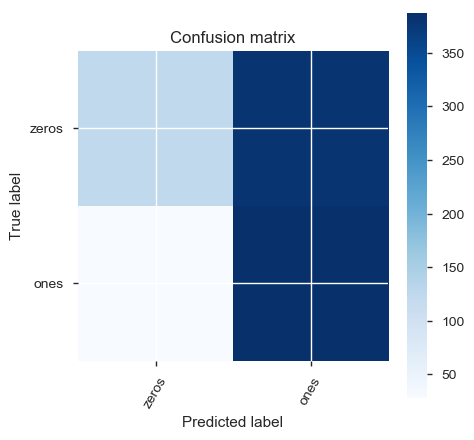

GaussianNB(priors=None, var_smoothing=1e-09)

In [33]:
gnb = GaussianNB()

print_stats(gnb, X_train, X_test, y_train, y_test)

gnb.fit(X_train, y_train)

<a id='rf'></a>
## RANDOM FOREST

We use the same method as above for random forest hyper parameter tuning using 3 fold cross validation and then fit the best possible model for random forest and test using the test data. 

An interesting observation with random forest is that it performs very poorly at correctly identifying the 0s (low specificity). So we will have to be careful about including it in an ensemble of models at a later stage.

Like XGBoost random forest also gives as a feature importance metric which might be useful at a later stage if we want to look at models using only the most important features

In [ ]:
# DO A GRIDSEARCH ON XGBOOST MODEL
n_estimators = [ 50, 60, 70, 80, 90]  
max_features = [5, 6]  
min_samples_leaf = [10,50, 200,500]

param_RandomForest = {'n_estimators':n_estimators, 'max_features':max_features, 'min_samples_leaf': min_samples_leaf}
param_RandomForest

In [ ]:
model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid=param_RandomForest, scoring="roc_auc", verbose=1 )
grid_search.fit(X_train, y_train) #Default 3 folds
print(grid_search.best_score_)
print(grid_search.best_params_)  

Number of mislabeled points out of a total 917 testing points : 156
('The hit rate on the testing set: ', 0.8298800436205016)

precision = 0.860, recall = 0.952, specificity= 0.212 F1 = 0.903, accuracy = 0.830

*********** AUC for ROC = 0.688 *********************

          0         1
0  0.463768  0.043632
1  1.724638  0.859670 

The confusion matrix on the testing set: 
      0    1
0   32   37
1  119  729


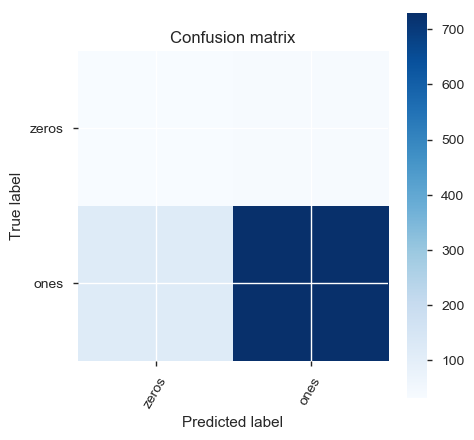

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
rf = RandomForestClassifier(max_features = 10, n_estimators = 80, min_samples_leaf =10)
print_stats(rf, X_train, X_test, y_train, y_test)
rf.fit(X_train,y_train)

## GET FEATURE IMPORTANCE FROM RANDOM FOREST

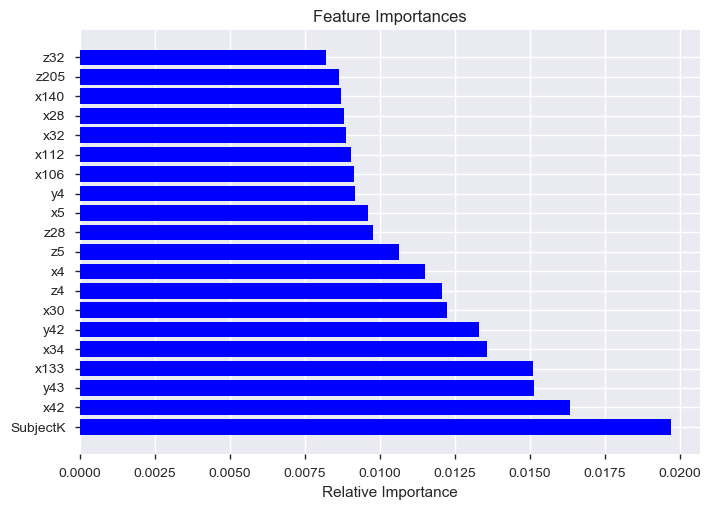

In [35]:
rf.feature_importances_
feature_importance(rf.feature_importances_, X_train.columns, 20)

<a id='lda'></a>
## LDA

C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Number of mislabeled points out of a total 917 testing points : 285
('The hit rate on the testing set: ', 0.6892039258451472)

precision = 0.932, recall = 0.678, specificity= 0.748 F1 = 0.785, accuracy = 0.689

*********** AUC for ROC = 0.780 *********************

          0         1
0  0.313889  0.443447
1  0.105556  0.931777 

The confusion matrix on the testing set: 
      0    1
0  113  247
1   38  519


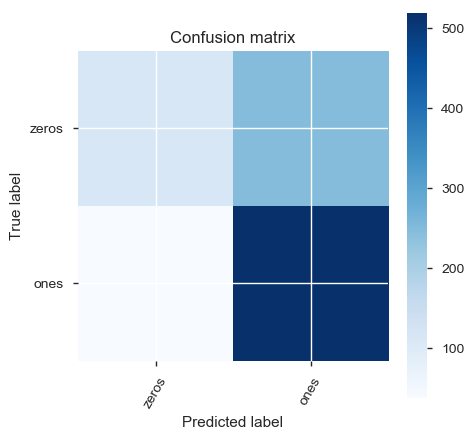

C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [72]:
lda = LinearDiscriminantAnalysis()
print_stats(lda, X_train_std, X_test_std, y_train, y_test)

In [117]:
lda.fit(X_train_std, y_train)
_ = generate_file(lda, test_output, "lda.csv")

C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


<a id='svm'></a>
## SUPPORT VECTOR MACHINE

C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Number of mislabeled points out of a total 917 testing points : 210
('The hit rate on the testing set: ', 0.7709923664122137)

precision = 0.877, recall = 0.845, specificity= 0.397 F1 = 0.860, accuracy = 0.771

*********** AUC for ROC = 0.670 *********************

          0         1
0  0.335196  0.161247
1  0.508380  0.876694 

The confusion matrix on the testing set: 
     0    1
0  60  119
1  91  647


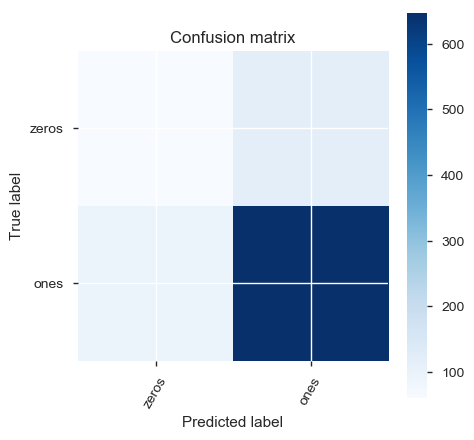

C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [73]:
svm = SVC(probability=True)
print_stats(svm, X_train_std, X_test_std, y_train, y_test)
svm.fit(X_train_std, y_train)

<a id='stack'></a>
## STACK THE RESULTS OF DIFFERENT MODELS

After collecting the results on our test set for each model that we tried out, we tried to use a second level model to converge the probabilities generated by each model and different combinations of models. The results on the test set for different combinations are below:


|                                     |       |             |        |       | 
|-------------------------------------|-------|-------------|--------|-------| 
| MODEL                               | AUC   | SPECIFICITY | RECALL | F1    | 
| XGBOOST                             | 0.74  | 0.656       | 0.645  | 0.753 | 
| Logistic Regression                 | 0.76  | 0.702       | 0.691  | 0.79  | 
| Naïve Bayes                         | 0.67  | 0.815       | 0.505  | 0.655 | 
| Random Forest                       | 0.688 | 0.212       | 0.953  | 0.9   | 
| LDA                                 | 0.78  | 0.748       | 0.678  | 0.785 | 
| SVM                                 | 0.677 | 0.397       | 0.845  | 0.86  | 
|                                     |       |             |        |       | 
| STACK (LDA):                        |       |             |        |       | 
| LDA, XGBOOST, BIN                   | 0.73  | 0.59        | 0.78   | 0.84  | 
| XGBoost, NaiveBayes, LDA            | 0.775 | 0.661       | 0.747  | 0.82  | 
| XGBOOST, Logistic, Naïve Bayes, LDA | 0.77  | 0.61        | 0.74   | 0.817 | 


We can see that some models like Random Forest scores very well on recall (predicting 1s correctly) but doesnt do that well on specificity (predicting 0s) correctly. Whereas Naive Bayes has the opposite scoring charectaristics. We tried to put models that have very different scoring characteristics in the stacked model to get the best possible score on the test set. 

Apart from stacking we also tried to feed the catagorical variables to the second level model.  

We also looked at the most important features from XGBoost and Random Forests and tried to feed those features into the second level model to see if they would help improve the scores.  

But, none of the above attempts yeilded better results so the INCLUDE_BIN and INCLUDE_TOP_FEATURES variables are set to 'False'
below


In [164]:
def create_base_predictions (list_data):
    return_list = []
    for X, X_std, X_PCA in list_data:
        base_predictions = pd.DataFrame( 
          {'XGBoost': list(xgb_model.predict_proba(X)[:,1]),
           'LogisticR': list(lr.predict_proba(X)[:,1]),
           #'NaiveBayes': list(gnb.predict_proba(X)[:,1]),
           #'RandomForeset': list(rf.predict_proba(X)[:,1]),
           'LDA': list(lda.predict_proba(X)[:,1]),
           #'SVM': list(svm.predict_proba(X_std)[:,1])
          })
        return_list.append(base_predictions)
    return return_list[0], return_list[1], return_list[2]
 
# A list of 3 data sets : Training, Test, Test_output(output is the test data on which the submit predictions have to be made)
data_list = [(X_train, X_train_std, X_train_PCA), \
             (X_test, X_test_std, X_test_PCA), \
             (test_output, test_output_std, test_output_PCA)]
                                                                                    
training_preds, test_preds, output_preds = create_base_predictions(data_list)

INCLUDE_BIN = False

INCLUDE_TOP_FEATURES = False
TOP_FEATURES = ['x42', 'SubjectK', 'z28', 'x28']
TOP_FEATURES = ['x42','SubjectK']


if INCLUDE_BIN: 
# Add back the binary features to see if results improve
    training_preds[bin_features] = X_train_binary
    test_preds[bin_features] = X_test_binary
    output_preds[bin_features] = test_output_binary
    
    
if INCLUDE_TOP_FEATURES:
    training_preds[TOP_FEATURES ] = X_train[TOP_FEATURES ].reset_index(drop=True)
    test_preds[TOP_FEATURES ] = X_test[TOP_FEATURES ].reset_index(drop=True)
    output_preds[TOP_FEATURES ] = test_output[TOP_FEATURES ].reset_index(drop=True)   

print(training_preds.shape)
print(y_train.shape)
print(y_train.value_counts())
print(test_preds.shape)
print(y_test.shape)
print(y_test.value_counts())
print(output_preds.shape)

C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


(6214, 3)
(6214,)
1    3107
0    3107
Name: 0, dtype: int64
(917, 3)
(917,)
1    766
0    151
Name: output, dtype: int64
(1732, 3)


C:\Users\shkhan2\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:510: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



## TRY OUT DIFFERENT TYPES MODELS IN THE SECOND LEVEL AND COMPARE SCORES

Number of mislabeled points out of a total 917 testing points : 172
('The hit rate on the testing set: ', 0.8124318429661941)

precision = 0.861, recall = 0.924, specificity= 0.245 F1 = 0.892, accuracy = 0.812

*********** AUC for ROC = 0.741 *********************

          0         1
0  0.389474  0.070560
1  1.200000  0.861314 

The confusion matrix on the testing set: 
      0    1
0   37   58
1  114  708


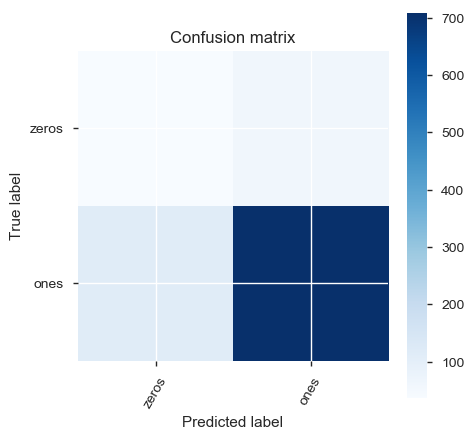

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.9, learning_rate=0.01,
       max_delta_step=0, max_depth=6, min_child_weight=2, missing=None,
       n_estimators=700, n_jobs=1, nthread=-1, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [165]:
gbm_stack = xgb.XGBClassifier(
 learning_rate = 0.01,
 n_estimators= 700,
 max_depth= 6,  
 min_child_weight= 2,
 gamma=0.9,   #Regularization parameter                     
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1)


rf_stack = RandomForestClassifier(max_features = 1, n_estimators = 50, min_samples_leaf =50)
gnb_stack = GaussianNB()
lda_stack = LinearDiscriminantAnalysis()
lg_stack = LogisticRegression()

# CHANGE THIS TO CHOOSE A DIFFERENT STACKING MODEL
STACK_MODEL = gbm_stack

# PRINT STATS AND FIT ON THE TRAINING SET
print_stats(STACK_MODEL, training_preds, test_preds, y_train, y_test)
STACK_MODEL.fit(training_preds,y_train)

In [143]:
_ = generate_file (STACK_MODEL, output_preds, "stack.csv") 